# Urine Marking Elo Score Calculation

## Importing other Python Libraries/Modules

In [1]:
import re
import os
import sys
import string
from collections import defaultdict
import glob
import warnings
from datetime import datetime
from datetime import timedelta
import ast

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xlrd

In [3]:
# setting path
sys.path.append('../../../src')

In [4]:
from eloscore import eloscore

In [5]:
# Increase size of plot in jupyter

plt.rcParams["figure.figsize"] = (18,10)

# Summary

- Experiment
    - Observing competitve behavior between two mice on top of a paper that records the urine marks. Mice are categorized as winner and loser based on the number of urine marks.
- Data
    - Excel spreadsheet of recorded tube test results. The relevant columns are those of the "Date" of the recording, the "winner" of the interaction, and the "loser" of the interaction. Each row will be for one interaction between two mice.
    - There is a cage for each sheet of the spreadsheet
    - For each recording session, we will assume that the date will be specified for that first row. We will use this to seperate all the rows into seperate sessions.
- Purpose of this Jupyter Notebook
    - To calculate the Elo Score of each mice after each interaction. The mice start off with an Elo score of 1000. Elo scores are calculated with the formula from here: https://www.omnicalculator.com/sports/elo . Then we will plot the change of elo score across all interactions. With the number of interactions on the X-Axis and the current Elo score on the Y. There will be a line for mice.

## Name of protocol for naming

- This name will be used to name files and title plots. Please change if you are using a different protocol or adding more details
    - **NOTE**: This should be changed based on the name the protocol

In [6]:
protocol_name = "urine_marking"

In [7]:
cohort_name = "pilot_1"

## Getting the file name of the raw data

- Default input folder and keyword to search the files for 
    - **NOTE**: This should not be changed unless there is a consistent change with the file naming convention

In [8]:
input_folder = "./data"

In [9]:
# Accomodates for both capitalization of the file names
raw_data_file_keyword = '*[tT]ube*'

# NOTE: If there is a set excel file used for this notebook, edit the cell below with the path to that in the "" (quotation marks)

In [10]:
raw_data_file_path = "./data/iwata_Urine_Marking_Assay_Data.xlsx"

- Asking the user what the path to the recording files are, with the option of using wildcards

In [11]:
if not raw_data_file_path:
    keyworraw_data_glob_pattern = input("""Type out the path(address) of the raw behavioral recording excel sheets.
    Remember that if you are using a relative path, it will be based off of the location of this Jupyter Notebook.

    Globbing can also be used if you want to search with a wild card(Capitalization matters). 
    i.e. './data/*Home*' will be able to find './data/Homecage_observations.xlsx'

    NOTE: If left blank, the path will automatically be guessed off of the default settings 
    """)

- By default, this will search for files that are in the `./data` folder (in the folder that this notebook is in) that have key word you specified in the file name

In [12]:
if not raw_data_file_path:
    # Using the user inputted path/pattern
    if raw_data_glob_pattern.strip():
        # Getting a list of all matching files
        raw_data_files_list = glob.glob(raw_data_glob_pattern.strip())
        # Checking if there were any files that matched
        if raw_data_files_list:
            raw_data_file_path = raw_data_files_list[0]
        else:
            raise ValueError("No files were found with the path/pattern of {}. Please rerun the previous cell with the correct path".format(raw_data_glob_pattern))

    # Using the default pattern
    else:
        # Searching for matching files with recursion
        if glob.glob(os.path.join(input_folder + "**", raw_data_file_keyword)):
            raw_data_glob_pattern = os.path.join(input_folder + "**", raw_data_file_keyword)
            # Getting a list of all matching files
            raw_data_files_list = glob.glob(raw_data_glob_pattern)
        # Searching for matching files only in the specified folder
        elif glob.glob(os.path.join(input_folder, raw_data_file_keyword)):
            raw_data_glob_pattern = glob.glob(os.path.join(input_folder, raw_data_file_keyword))
            # Getting a list of all matching files
            raw_data_files_list = glob.glob(raw_data_glob_pattern)
        else:
            raise ValueError("No files were found in {} that had the keyword {} in it".format(input_folder, raw_data_file_keyword))


- Checking to see if only one file is specified

In [13]:
if not raw_data_file_path:
    if len(raw_data_files_list) >= 2:
        raise ValueError("More than one file was found with the path/pattern of {}. Please rerun the previous cell with the correct path".format(raw_data_glob_pattern))
    else:
        # Using the first(and only file) as the file path
        raw_data_file_path = raw_data_files_list[0]

In [14]:
raw_data_file_path

'./data/iwata_Urine_Marking_Assay_Data.xlsx'

## Getting a list of all the sheets

In [15]:
# Getting the sheet names for the excel file
xls = pd.ExcelFile(raw_data_file_path)
raw_data_sheet_names = xls.sheet_names

In [16]:
raw_data_sheet_names

['Summary',
 'CAGE1',
 'CAGE2',
 'CAGE3',
 'CAGE4',
 'ALLDATA',
 '_56F9DC9755BA473782653E2940F9']

# NOTE: If there is a set sheet names used for this notebook, edit the cell below with the name of the sheets each in quotation marks seperated by commas
   - i.e. `['CAGE 1', 'CAGE 2', 'CAGE 3', 'CAGE 4']`

In [17]:
inputted_sheet_names_list = ['CAGE1', 'CAGE2', 'CAGE3', 'CAGE4']

- Asking the user what sheets they want to use

In [18]:
if not inputted_sheet_names_list:
    inputted_sheet_names_string = input("""Type out the name of the sheets that you want to be processed. 
    Each name must be put in quotes and seperated by a comma(,). i.e. "CAGE3", "CAGE4"

    The available sheets are: {}

    Alternatively, you can use the index of the list of names above. 
    Remember, that Python is zero indexed so the first item will be have the 0 index, second the 1 index, and so on. 
    i.e. 1, 2

    NOTE: If left blank, all sheets will be used
    """.format(raw_data_sheet_names))

In [19]:
if not inputted_sheet_names_list:
    # Making a list out of the string of inputted sheet names
    if inputted_sheet_names_string:
        inputted_sheet_names_string = "[" + inputted_sheet_names_string + "]"
        # Turning the string into a list
        inputted_sheet_names_list = ast.literal_eval(inputted_sheet_names_string)
    # Using all the sheet names if no sheet name is specified
    else:
        inputted_sheet_names_list =  raw_data_sheet_names

In [20]:
inputted_sheet_names_list

['CAGE1', 'CAGE2', 'CAGE3', 'CAGE4']

- Converting all the numbers into the sheet name that the index of the number corresponds to

In [21]:
if not inputted_sheet_names_list:
    for index, sheet in enumerate(inputted_sheet_names_list):
        # Checking if the sheet name was a number
        if isinstance(sheet, int) and str(sheet).isdigit():
            inputted_sheet_names_list[index] =  raw_data_sheet_names[sheet]

In [22]:
inputted_sheet_names_list

['CAGE1', 'CAGE2', 'CAGE3', 'CAGE4']

- Checking to see if all the sheets are in the excel file

In [23]:
if not set(inputted_sheet_names_list).issubset(raw_data_sheet_names):
    # Getting all the sheets that were not in the original spreadsheet
    not_included_sheet_names = set(inputted_sheet_names_list) - set(raw_data_sheet_names)
    raise ValueError("All the listed sheet names are not in {}".format(not_included_sheet_names))

## Finding the row for the header

- Headers are the row in a spreadsheet that has all the column names. Sometimes spreadsheets don't use the first row as the row with the column names. So, the row for the header will be asked or assumed to be the first row

# NOTE: If there is a set row that has the column names, then enter the row number in the quotation marks

In [24]:
# Making the row number a string, so that "0" is treated as a True value
all_header_row = header_row = "0"
header_row = int(header_row)

In [25]:
sheet_name_to_everything = defaultdict(dict)
for sheet in inputted_sheet_names_list:
    if not all_header_row:

        print("\nCurrent Sheet Name: {}".format(sheet))    
        per_sheet_dataframe = pd.read_excel(raw_data_file_path, sheet_name=sheet, header=0)

        # Showing the columns that are chosen with the header being the 0th row
        print("Columns Names: {}".format(per_sheet_dataframe.columns))
        # Show the dataframe that would be created with the header being the 0th row
        print("First few rows of this dataframe:")
        print(pd.read_excel(raw_data_file_path, sheet_name=sheet, header=0).head())

        # Allowing the user the choose the row number for the header
        header_row = input("""Type the row number to be used as the header
        (AKA the row with the column name that you want to use.)
        If you want to keep the column names that were displayed, type 0.
        If you want to use a different row, then type the corresponding number. 

        The rows displayed in this cell are dataframes created from Pandas. 
        To use the row with the 0 index for column names, type 1. 
        For the row with the 1 index, it will be 2 and so on. i.e. 2

        If you are looking at the original spread sheet, remember that Python is zero indexed. 
        So the first row will be 0, second will be 1, and so on. 
        i.e. 1

        NOTE: If left blank, the original row that was used will be used.
        """).strip()

        if header_row == "":
            header_row = 0
        else:
            header_row = int(header_row)
    
    # Checking if any of the column names are from empty cells
    column_names = "".join([str(col) for col in pd.read_excel(raw_data_file_path, sheet_name=sheet, header=header_row).columns])
    # If a column name came from an empty cell, it would have "Unnamed" in it
    if "Unnamed" in column_names:
        raise ValueError("""Not all the cells in the chosen row are filled in.
                         Please choose a row that has the name of the columns
                         
                         The values in this row are: {}""".format(column_names))
    else:
        sheet_name_to_everything[sheet]["header_row"] = header_row

In [26]:
sheet_name_to_everything

defaultdict(dict,
            {'CAGE1': {'header_row': 0},
             'CAGE2': {'header_row': 0},
             'CAGE3': {'header_row': 0},
             'CAGE4': {'header_row': 0}})

## Reading in all the spreadsheets

In [27]:
# Going through each sheet and creating a dataframe of it
for key, value in sheet_name_to_everything.items():
    sheet_name_to_everything[key]["original_behavior_recording_dataframe"] = pd.read_excel(raw_data_file_path, sheet_name=key, header=value["header_row"])

In [28]:
sheet_name_to_everything[key]["original_behavior_recording_dataframe"].head()

,date,match,left_number_of_spots,right_number_of_spots,winner,loser,ties
0,2022-05-18,4.1 v 4.2,97,45,4.1,4.2,NaN
1,2022-05-18,4.3 v 4.4,79,93,4.4,4.3,NaN
2,2022-05-19,4.1 v 4.2,25,78,4.2,4.1,NaN
3,2022-05-19,4.3 v 4.4,22,117,4.4,4.3,NaN
4,2022-05-20,4.1 v 4.3,10,0,4.1,4.3,NaN


In [29]:
sheet_name_to_everything[key]["original_behavior_recording_dataframe"].tail()

,date,match,left_number_of_spots,right_number_of_spots,winner,loser,ties
6,2022-05-24,4.1 v 4.4,26,137,4.4,4.1,NaN
7,2022-05-24,4.2 v 4.3,20,24,4.3,4.2,NaN
8,2022-05-25,4.1 v 4.2,21,9,4.1,4.2,NaN
9,2022-05-27,4.3 v 4.4,18,308,4.4,4.3,NaN
10,2022-06-01,4.3 v 4.4,3,71,4.4,4.3,NaN


## Standarizing the Columns

- Making all the column names lower case and removing any extra spaces in the beginning and at the end

In [30]:
for key, value in sheet_name_to_everything.items():
    # Creating a dictionary that maps the original column name to the standarized one
    column_name_to_standarized = defaultdict(dict)
    for col in sheet_name_to_everything[key]["original_behavior_recording_dataframe"]:
        # Making the column name lower case and removing the spaces
        column_name_to_standarized[col] = "_".join(str(col).lower().strip().split(" "))
    sheet_name_to_everything[key]["column_name_to_standarized"] = column_name_to_standarized

In [31]:
sheet_name_to_everything[key]["column_name_to_standarized"]

defaultdict(dict,
            {'date': 'date',
             'match': 'match',
             'left_number_of_spots': 'left_number_of_spots',
             'right_number_of_spots': 'right_number_of_spots',
             'winner': 'winner',
             'loser': 'loser',
             'ties': 'ties'})

In [32]:
# Renaming all the columns to the lower case and space removed version
for key, value in sheet_name_to_everything.items():
    sheet_name_to_everything[key]["processed_behavior_recording_dataframe"] = sheet_name_to_everything[key]["original_behavior_recording_dataframe"].rename(columns=sheet_name_to_everything[key]["column_name_to_standarized"])


In [33]:
sheet_name_to_everything[key]["processed_behavior_recording_dataframe"].head()

,date,match,left_number_of_spots,right_number_of_spots,winner,loser,ties
0,2022-05-18,4.1 v 4.2,97,45,4.1,4.2,NaN
1,2022-05-18,4.3 v 4.4,79,93,4.4,4.3,NaN
2,2022-05-19,4.1 v 4.2,25,78,4.2,4.1,NaN
3,2022-05-19,4.3 v 4.4,22,117,4.4,4.3,NaN
4,2022-05-20,4.1 v 4.3,10,0,4.1,4.3,NaN


## Adding the session number

- We are adding the session number to all the trials. The session number is counting the number of recording sessions that have happened up until that trial. Usually, each session in the spreadsheet is divided up by a session's first row having the date filled in. So we will label a new session when a date is filled in.

# NOTE: If there is a set column that divides the rows up by session, then enter it in the cell below between the quotation marks

In [34]:
all_session_divider_column = session_divider_column = "date"

In [35]:
for key, value in sheet_name_to_everything.items():
    if not all_session_divider_column:
        # Allowing the user to choose the column that indicates a new session
        session_divider_column = input("""Type the name of the column to be used to divide the rows into sessions. 
        Pick a column that has a value in the cell only with the first row of each session.
        This is usually the "date" column.

        If left blank, the default session divider column will be used. The default is "date"

        The available columns are: {}

        NOTE: If left blank, the column with "date" in the name will be used as the column
        """.format(sheet_name_to_everything[key]["processed_behavior_recording_dataframe"].columns))
    # Making the column name lowercase and removing any punctuation
    sheet_name_to_everything[key]["session_divider_column"] = session_divider_column.lower().strip('"').strip("'").strip()

    # Looks for columns with "date" in them if none of inputted
    if not sheet_name_to_everything[key]["session_divider_column"]:
        sheet_name_to_everything[key]["session_divider_column"] = [col for col in sheet_name_to_everything[key]["processed_behavior_recording_dataframe"].columns if "date" in col.lower()][0]

    # Checks if that column is in the dataframe
    if sheet_name_to_everything[key]["session_divider_column"] not in sheet_name_to_everything[key]["processed_behavior_recording_dataframe"].columns:
        raise ValueError("{} is not a column in {}".format(sheet_name_to_everything[key]["session_divider_column"], sheet_name_to_everything[key]["processed_behavior_recording_dataframe"].columns)) 

In [36]:
for key, value in sheet_name_to_everything.items():
    # Getting the indexes of all the rows that have the date or the column that divides the sessions up
    sheet_name_to_everything[key]["session_indexes"] = sheet_name_to_everything[key]["processed_behavior_recording_dataframe"].dropna(axis=0, subset=sheet_name_to_everything[key]["session_divider_column"]).index
    # Adding the session number to each row
    sheet_name_to_everything[key]["processed_behavior_recording_dataframe"] = eloscore.add_session_number_column(sheet_name_to_everything[key]["processed_behavior_recording_dataframe"], sheet_name_to_everything[key]["session_indexes"], session_number_column='session_number')
    
    # Filling in the NaNs for the session number
    sheet_name_to_everything[key]["processed_behavior_recording_dataframe"]["session_number"] = sheet_name_to_everything[key]["processed_behavior_recording_dataframe"]["session_number"].fillna(method='ffill')

In [37]:
sheet_name_to_everything[key]["processed_behavior_recording_dataframe"].head()

,date,match,left_number_of_spots,right_number_of_spots,winner,loser,ties,session_number
0,2022-05-18,4.1 v 4.2,97,45,4.1,4.2,NaN,1.0
1,2022-05-18,4.3 v 4.4,79,93,4.4,4.3,NaN,2.0
2,2022-05-19,4.1 v 4.2,25,78,4.2,4.1,NaN,3.0
3,2022-05-19,4.3 v 4.4,22,117,4.4,4.3,NaN,4.0
4,2022-05-20,4.1 v 4.3,10,0,4.1,4.3,NaN,5.0


In [38]:
sheet_name_to_everything[key]["processed_behavior_recording_dataframe"].tail()

,date,match,left_number_of_spots,right_number_of_spots,winner,loser,ties,session_number
6,2022-05-24,4.1 v 4.4,26,137,4.4,4.1,NaN,7.0
7,2022-05-24,4.2 v 4.3,20,24,4.3,4.2,NaN,8.0
8,2022-05-25,4.1 v 4.2,21,9,4.1,4.2,NaN,9.0
9,2022-05-27,4.3 v 4.4,18,308,4.4,4.3,NaN,10.0
10,2022-06-01,4.3 v 4.4,3,71,4.4,4.3,NaN,11.0


## Dropping All Rows without a Winner

- Because we will be filling all empty cells with the previous value, we must remove all rows that don't have any data. This is usually cells that don't have any winners or losers filled in the row.

In [39]:
all_winner_column = winner_column = "winner"
all_loser_column = loser_column = "loser"

In [40]:
for key, value in sheet_name_to_everything.items():
    if not all_winner_column:
        # Asking users to specify which column is the one with the winner's information
        sheet_name_to_everything[key]["winner_column"] = input("""Type the name of the column of the subject that has won the interaction.
        i.e. "winner"

        The available columns are: {}

        Note: If left blank, the column with "winner" in the name will be used as the column
        """.format(sheet_name_to_everything[key]["processed_behavior_recording_dataframe"].columns))
    
    
        # Looks for columns with "winner" in them if none of inputted
        if not sheet_name_to_everything[key]["winner_column"]:
            sheet_name_to_everything[key]["winner_column"] = [col for col in sheet_name_to_everything[key]["processed_behavior_recording_dataframe"].columns if "winner" in col.lower()][0]
    else:
        sheet_name_to_everything[key]["winner_column"] = all_winner_column
        
    if not all_loser_column:   
        # Asking users to specify which column is the one with the winner's information
        sheet_name_to_everything[key]["loser_column"] = input("""Type the name of the column of the subject that has won the interaction.
        i.e. "loser"

        The available columns are: {}

        Note: If left blank, the column with "loser" in the name will be used as the column
        """.format(sheet_name_to_everything[key]["processed_behavior_recording_dataframe"].columns))

        # Looks for columns with "loser" in them if none of inputted
        if not sheet_name_to_everything[key]["loser_column"]:
            sheet_name_to_everything[key]["loser_column"] = [col for col in sheet_name_to_everything[key]["processed_behavior_recording_dataframe"].columns if "loser" in col.lower()][0]
    else:
        sheet_name_to_everything[key]["loser_column"] = all_loser_column
    # Dropping all rows that don't have any values in the winner column
    sheet_name_to_everything[key]["processed_behavior_recording_dataframe"] = sheet_name_to_everything[key]["processed_behavior_recording_dataframe"].dropna(subset=sheet_name_to_everything[key]["winner_column"])
    
    sheet_name_to_everything[key]["processed_behavior_recording_dataframe"][sheet_name_to_everything[key]["winner_column"]] = sheet_name_to_everything[key]["processed_behavior_recording_dataframe"][sheet_name_to_everything[key]["winner_column"]].astype(str).apply(lambda x: re.findall(r"[-+]?(?:\d*\.\d+|\d+)", x)[0] if re.findall(r"[-+]?(?:\d*\.\d+|\d+)", x) else x)
    sheet_name_to_everything[key]["processed_behavior_recording_dataframe"][sheet_name_to_everything[key]["loser_column"]] = sheet_name_to_everything[key]["processed_behavior_recording_dataframe"][sheet_name_to_everything[key]["loser_column"]].astype(str).apply(lambda x: re.findall(r"[-+]?(?:\d*\.\d+|\d+)", x)[0] if re.findall(r"[-+]?(?:\d*\.\d+|\d+)", x) else x)

In [41]:
sheet_name_to_everything[key]["processed_behavior_recording_dataframe"].head()

,date,match,left_number_of_spots,right_number_of_spots,winner,loser,ties,session_number
0,2022-05-18,4.1 v 4.2,97,45,4.1,4.2,NaN,1.0
1,2022-05-18,4.3 v 4.4,79,93,4.4,4.3,NaN,2.0
2,2022-05-19,4.1 v 4.2,25,78,4.2,4.1,NaN,3.0
3,2022-05-19,4.3 v 4.4,22,117,4.4,4.3,NaN,4.0
4,2022-05-20,4.1 v 4.3,10,0,4.1,4.3,NaN,5.0


In [42]:
sheet_name_to_everything[key]["processed_behavior_recording_dataframe"].tail()

,date,match,left_number_of_spots,right_number_of_spots,winner,loser,ties,session_number
6,2022-05-24,4.1 v 4.4,26,137,4.4,4.1,NaN,7.0
7,2022-05-24,4.2 v 4.3,20,24,4.3,4.2,NaN,8.0
8,2022-05-25,4.1 v 4.2,21,9,4.1,4.2,NaN,9.0
9,2022-05-27,4.3 v 4.4,18,308,4.4,4.3,NaN,10.0
10,2022-06-01,4.3 v 4.4,3,71,4.4,4.3,NaN,11.0


# Finding the rows with ties

- If a trial is a tie, there should be another column that indicates that it is a tie. The points will be counted for less. If there is no column, then none of the trials will be counted as ties.

# NOTE: If there is a set column that denotes whether the match has a winner or not, then replace the `None` with the name of the column with quotation marks

In [43]:
all_ties_column = "ties"

In [44]:
for key, value in sheet_name_to_everything.items():
    
    if all_ties_column is None:
        sheet_name_to_everything[key]["ties_column"] = None
    elif all_ties_column:
        sheet_name_to_everything[key]["ties_column"] = all_ties_column
    else:
    
        # Asking users to specify which column is the one with the winner's information
        sheet_name_to_everything[key]["ties_column"] = input("""Type the name of the column that specifies whether or not a tie has occured
        i.e. "ties"

        The available columns are: {}

        Note: If left blank, the column with "ties" in the name will be used as the column. 
        If there are none, then this part will be skipped

        """.format(sheet_name_to_everything[key]["processed_behavior_recording_dataframe"].columns))

        # Looks for columns with "winner" in them if none of inputted
        if not sheet_name_to_everything[key]["ties_column"]:
            if [col for col in sheet_name_to_everything[key]["processed_behavior_recording_dataframe"].columns if "ties" in col.lower()]:
                sheet_name_to_everything[key]["ties_column"] = [col for col in sheet_name_to_everything[key]["processed_behavior_recording_dataframe"].columns if "ties" in col.lower()][0]
            else: 
                sheet_name_to_everything[key]["ties_column"] = None

# Getting the Session number differences

- Getting the indexes of where each new session starts. So that we can add the session number to each row.

In [45]:
list(set(sheet_name_to_everything[key]["processed_behavior_recording_dataframe"].columns) - set([sheet_name_to_everything[key]["ties_column"]]))

['winner',
 'loser',
 'left_number_of_spots',
 'right_number_of_spots',
 'match',
 'session_number',
 'date']

In [46]:
for key, value in sheet_name_to_everything.items():
    if sheet_name_to_everything[key]["ties_column"]:
        non_ties_columns = list(set(sheet_name_to_everything[key]["processed_behavior_recording_dataframe"].columns) - set([sheet_name_to_everything[key]["ties_column"]]))
        sheet_name_to_everything[key]["processed_behavior_recording_dataframe"][non_ties_columns] = sheet_name_to_everything[key]["processed_behavior_recording_dataframe"][non_ties_columns].fillna(method='ffill')
    else:
        # Filling all the empty cells with the value in the previous cell
        sheet_name_to_everything[key]["processed_behavior_recording_dataframe"] = sheet_name_to_everything[key]["processed_behavior_recording_dataframe"].fillna(method='ffill')

     # Seeing which rows have a different session than the previous one
    # This will be used to plot vertical lines for each new session
    sheet_name_to_everything[key]["processed_behavior_recording_dataframe"]['session_number_difference'] = sheet_name_to_everything[key]["processed_behavior_recording_dataframe"]['session_number'].diff()

In [47]:
sheet_name_to_everything[key]["processed_behavior_recording_dataframe"].head(n=15)

,date,match,left_number_of_spots,right_number_of_spots,winner,loser,ties,session_number,session_number_difference
0,2022-05-18,4.1 v 4.2,97,45,4.1,4.2,NaN,1.0,NaN
1,2022-05-18,4.3 v 4.4,79,93,4.4,4.3,NaN,2.0,1.0
2,2022-05-19,4.1 v 4.2,25,78,4.2,4.1,NaN,3.0,1.0
3,2022-05-19,4.3 v 4.4,22,117,4.4,4.3,NaN,4.0,1.0
4,2022-05-20,4.1 v 4.3,10,0,4.1,4.3,NaN,5.0,1.0
5,2022-05-20,4.2 v 4.4,5,70,4.4,4.2,NaN,6.0,1.0
6,2022-05-24,4.1 v 4.4,26,137,4.4,4.1,NaN,7.0,1.0
7,2022-05-24,4.2 v 4.3,20,24,4.3,4.2,NaN,8.0,1.0
8,2022-05-25,4.1 v 4.2,21,9,4.1,4.2,NaN,9.0,1.0
9,2022-05-27,4.3 v 4.4,18,308,4.4,4.3,NaN,10.0,1.0


In [48]:
sheet_name_to_everything[key]["processed_behavior_recording_dataframe"].tail(n=15)

,date,match,left_number_of_spots,right_number_of_spots,winner,loser,ties,session_number,session_number_difference
0,2022-05-18,4.1 v 4.2,97,45,4.1,4.2,NaN,1.0,NaN
1,2022-05-18,4.3 v 4.4,79,93,4.4,4.3,NaN,2.0,1.0
2,2022-05-19,4.1 v 4.2,25,78,4.2,4.1,NaN,3.0,1.0
3,2022-05-19,4.3 v 4.4,22,117,4.4,4.3,NaN,4.0,1.0
4,2022-05-20,4.1 v 4.3,10,0,4.1,4.3,NaN,5.0,1.0
5,2022-05-20,4.2 v 4.4,5,70,4.4,4.2,NaN,6.0,1.0
6,2022-05-24,4.1 v 4.4,26,137,4.4,4.1,NaN,7.0,1.0
7,2022-05-24,4.2 v 4.3,20,24,4.3,4.2,NaN,8.0,1.0
8,2022-05-25,4.1 v 4.2,21,9,4.1,4.2,NaN,9.0,1.0
9,2022-05-27,4.3 v 4.4,18,308,4.4,4.3,NaN,10.0,1.0


## Calculating ELO Score

- Example calculation

In [49]:
eloscore.calculate_elo_score(subject_elo_score=1000, agent_elo_score=2000)

1019.9

In [50]:
eloscore.update_elo_score(winner_id="A", loser_id="B")

defaultdict(<function eloscore.eloscore.update_elo_score.<locals>.<lambda>()>,
            {'A': 1010.0, 'B': 990.0})

## Get the Elo score for all the events

- Going through each row or interaction and calculating the new ELO score for the winner and loser. This will create a new dataframe based off of the processed behavioral recording dataframe

# NOTE: If there are a set of columns to keep, edit the cell below with the name of the columns each in quotation marks seperated by commas
   - i.e. `['runner', 'date', 'match', 'winner', 'loser', 'notes', 'session_number',
       'session_number_difference']`

In [51]:
all_columns_to_keep = ['date', 'match', 'left_number_of_spots', 'right_number_of_spots',
       'winner', 'loser', 'ties', 'session_number',
       'session_number_difference']

In [52]:
for key, value in sheet_name_to_everything.items():
    if not all_columns_to_keep:
        # Asking the user which columns to carry over to the ELO Score calculation dataframe
        sheet_name_to_everything[key]["columns_to_keep_string"] = input("""Type all the columns that will be copied from the original dataframe to the ELO Score calculated dataframe. 

        All the available actions: {}
        Each column must be put in quotes and seperated by a comma(,). i.e. 'length of observations', 'date', 'cage #'

        NOTE: If left blank, all the columns will be kept
        """.format(sheet_name_to_everything[key]["processed_behavior_recording_dataframe"].columns))


        # Making a list out of the string of inputted sheet names
        if sheet_name_to_everything[key]["columns_to_keep_string"]:
            sheet_name_to_everything[key]["columns_to_keep_string"] = "[" + sheet_name_to_everything[key]["columns_to_keep_string"] + "]"
            sheet_name_to_everything[key]["columns_to_keep_list"] = ast.literal_eval(sheet_name_to_everything[key]["columns_to_keep_string"])
        # Using all the sheet names if no sheet name is specified
        else:
            sheet_name_to_everything[key]["columns_to_keep_list"] =  sorted(list(set(sheet_name_to_everything[key]["processed_behavior_recording_dataframe"].columns) - set([sheet_name_to_everything[key]["winner_column"]]) - set([sheet_name_to_everything[key]["loser_column"]])))
    else: 
        sheet_name_to_everything[key]["columns_to_keep_list"] = all_columns_to_keep

    # Calculating the Elo Score    
    sheet_name_to_everything[key]["index_to_elo_score_and_meta_data"] = eloscore.iterate_elo_score_calculation_for_dataframe(dataframe=sheet_name_to_everything[key]["processed_behavior_recording_dataframe"], \
                                                                                                                   winner_column=sheet_name_to_everything[key]["winner_column"], loser_column=sheet_name_to_everything[key]["loser_column"], \
                                                                                                                             additional_columns=sheet_name_to_everything[key]["columns_to_keep_list"], tie_column=sheet_name_to_everything[key]["ties_column"])
    # Making a dataframe from the dictionary 
    sheet_name_to_everything[key]["elo_score_dataframe"] = pd.DataFrame.from_dict(sheet_name_to_everything[key]["index_to_elo_score_and_meta_data"], orient="index")


In [53]:
sheet_name_to_everything[key]["elo_score_dataframe"].head()

,total_match_number,subject_id,agent_id,original_elo_score,updated_elo_score,win_draw_loss,subject_ranking,agent_ranking,date,match,left_number_of_spots,right_number_of_spots,winner,loser,ties,session_number,session_number_difference
0,1,4.1,4.2,1000.0,1010.0,1,1,2,2022-05-18,4.1 v 4.2,97,45,4.1,4.2,NaN,1.0,NaN
1,1,4.2,4.1,1000.0,990.0,0,2,1,2022-05-18,4.1 v 4.2,97,45,4.1,4.2,NaN,1.0,NaN
2,2,4.4,4.3,1000.0,1010.0,1,2,4,2022-05-18,4.3 v 4.4,79,93,4.4,4.3,NaN,2.0,1.0
3,2,4.3,4.4,1000.0,990.0,0,4,2,2022-05-18,4.3 v 4.4,79,93,4.4,4.3,NaN,2.0,1.0
4,3,4.2,4.1,990.0,1000.6,1,2,3,2022-05-19,4.1 v 4.2,25,78,4.2,4.1,NaN,3.0,1.0


In [54]:
sheet_name_to_everything[key]["elo_score_dataframe"].tail()

,total_match_number,subject_id,agent_id,original_elo_score,updated_elo_score,win_draw_loss,subject_ranking,agent_ranking,date,match,left_number_of_spots,right_number_of_spots,winner,loser,ties,session_number,session_number_difference
17,9,4.2,4.1,980.5,971.0,0,4,2,2022-05-25,4.1 v 4.2,21,9,4.1,4.2,NaN,9.0,1.0
18,10,4.4,4.3,1038.3,1046.7,1,1,3,2022-05-27,4.3 v 4.4,18,308,4.4,4.3,NaN,10.0,1.0
19,10,4.3,4.4,981.7,973.3,0,3,1,2022-05-27,4.3 v 4.4,18,308,4.4,4.3,NaN,10.0,1.0
20,11,4.4,4.3,1046.7,1054.6,1,1,4,2022-06-01,4.3 v 4.4,3,71,4.4,4.3,NaN,11.0,1.0
21,11,4.3,4.4,973.3,965.4,0,4,1,2022-06-01,4.3 v 4.4,3,71,4.4,4.3,NaN,11.0,1.0


In [55]:
sheet_name_to_everything[key]["elo_score_dataframe"].groupby("subject_id").count()

,total_match_number,agent_id,original_elo_score,updated_elo_score,win_draw_loss,subject_ranking,agent_ranking,date,match,left_number_of_spots,right_number_of_spots,winner,loser,ties,session_number,session_number_difference
subject_id,,,,,,,,,,,,,,,,
4.1,5,5,5,5,5,5,5,5,5,5,5,5,5,0,5,4
4.2,5,5,5,5,5,5,5,5,5,5,5,5,5,0,5,4
4.3,6,6,6,6,6,6,6,6,6,6,6,6,6,0,6,6
4.4,6,6,6,6,6,6,6,6,6,6,6,6,6,0,6,6


## Getting the cage number

- The cage number is sometimes not consistent throughout a spreadsheet for the same cage. So we will try to standarize it into one value.
    - **NOTE**: This assumes cage numbers are actual numbers. And not entirely consisting of letters. If that isn't the case, then you must edit this cell for your needs.

# NOTE: If there are is a column that has the cage number information, replace the `None` with the column name in quotation marks

In [56]:
all_cage_column = None

In [57]:
for key, value in sheet_name_to_everything.items():
    if all_cage_column is not None:
        # Asking the user which column has the cage number
        sheet_name_to_everything[key]["cage_column"] = input("""Type the name of the column of the subject that has won the interaction.
        i.e. "cage"

        The available columns are: {}

        Note: If left blank, the column with "cage" will be used as the column. If there is none, then the sheet name will be used.
        """.format(sheet_name_to_everything[key]["processed_behavior_recording_dataframe"].columns))

        # Getting the column that has "cage" in its name if no column is specified
        if not sheet_name_to_everything[key]["cage_column"]:
            if [col for col in sheet_name_to_everything[key]["processed_behavior_recording_dataframe"].columns if "cage" in col.lower()]:
                sheet_name_to_everything[key]["cage_column"] = [col for col in sheet_name_to_everything[key]["processed_behavior_recording_dataframe"].columns if "cage" in col.lower()][0]
            else:
                sheet_name_to_everything[key]["cage_column"] = "cage"
                sheet_name_to_everything[key]["elo_score_dataframe"]["cage"] = key
    else:
        sheet_name_to_everything[key]["cage_column"] = all_cage_column
        sheet_name_to_everything[key]["elo_score_dataframe"]["cage"] = key

In [58]:
for key, value in sheet_name_to_everything.items():
     # Making a new column for the processed cage number
    if all_cage_column is not None:
        cage_column = sheet_name_to_everything[key]["cage_column"]
        sheet_name_to_everything[key]["elo_score_dataframe"]["processed_cage_number"] = sheet_name_to_everything[key]["elo_score_dataframe"][cage_column].apply(lambda x: re.findall(r'\d+', str(x))[0] if re.findall(r'\d+', str(x)) else x)
    else:
        sheet_name_to_everything[key]["elo_score_dataframe"]["processed_cage_number"] = sheet_name_to_everything[key]["elo_score_dataframe"]["cage"].apply(lambda x: re.findall(r'\d+', str(x))[0] if re.findall(r'\d+', str(x)) else x)   

In [59]:
sheet_name_to_everything[key]["elo_score_dataframe"].head()

,total_match_number,subject_id,agent_id,original_elo_score,updated_elo_score,win_draw_loss,subject_ranking,agent_ranking,date,match,left_number_of_spots,right_number_of_spots,winner,loser,ties,session_number,session_number_difference,cage,processed_cage_number
0,1,4.1,4.2,1000.0,1010.0,1,1,2,2022-05-18,4.1 v 4.2,97,45,4.1,4.2,NaN,1.0,NaN,CAGE4,4
1,1,4.2,4.1,1000.0,990.0,0,2,1,2022-05-18,4.1 v 4.2,97,45,4.1,4.2,NaN,1.0,NaN,CAGE4,4
2,2,4.4,4.3,1000.0,1010.0,1,2,4,2022-05-18,4.3 v 4.4,79,93,4.4,4.3,NaN,2.0,1.0,CAGE4,4
3,2,4.3,4.4,1000.0,990.0,0,4,2,2022-05-18,4.3 v 4.4,79,93,4.4,4.3,NaN,2.0,1.0,CAGE4,4
4,3,4.2,4.1,990.0,1000.6,1,2,3,2022-05-19,4.1 v 4.2,25,78,4.2,4.1,NaN,3.0,1.0,CAGE4,4


In [60]:
sheet_name_to_everything[key]["elo_score_dataframe"].tail()

,total_match_number,subject_id,agent_id,original_elo_score,updated_elo_score,win_draw_loss,subject_ranking,agent_ranking,date,match,left_number_of_spots,right_number_of_spots,winner,loser,ties,session_number,session_number_difference,cage,processed_cage_number
17,9,4.2,4.1,980.5,971.0,0,4,2,2022-05-25,4.1 v 4.2,21,9,4.1,4.2,NaN,9.0,1.0,CAGE4,4
18,10,4.4,4.3,1038.3,1046.7,1,1,3,2022-05-27,4.3 v 4.4,18,308,4.4,4.3,NaN,10.0,1.0,CAGE4,4
19,10,4.3,4.4,981.7,973.3,0,3,1,2022-05-27,4.3 v 4.4,18,308,4.4,4.3,NaN,10.0,1.0,CAGE4,4
20,11,4.4,4.3,1046.7,1054.6,1,1,4,2022-06-01,4.3 v 4.4,3,71,4.4,4.3,NaN,11.0,1.0,CAGE4,4
21,11,4.3,4.4,973.3,965.4,0,4,1,2022-06-01,4.3 v 4.4,3,71,4.4,4.3,NaN,11.0,1.0,CAGE4,4


## Combining all the ELO Score dataframes into one

In [61]:
# Adding the name of the experiment
for key, value in sheet_name_to_everything.items():
    sheet_name_to_everything[key]["elo_score_dataframe"]["experiment_type"] = "{}".format(protocol_name)

In [62]:
# Putting all the dataframes into one list
all_sheet_elo_scord_dataframe_list = []
for key, value in sheet_name_to_everything.items():    
    all_sheet_elo_scord_dataframe_list.append(sheet_name_to_everything[key]["elo_score_dataframe"])

# Combining all the dataframes into one
all_sheet_elo_scord_dataframe_combined = pd.concat(all_sheet_elo_scord_dataframe_list)

- Adding the strain information

# NOTE: If there are strains that are associated to each cage, then create a dictionary of cage numbers to strains inside the `{}`
- i.e. `cage_to_strain = {"1": "C57", "2": "C57", "3": "C57", "4": "CD1", "5": "CD1", "6": "CD1"}`

In [63]:
cage_to_strain = {"1": "C57", "2": "C57","3": "CD1", "4": "CD1"}

In [64]:
if cage_to_strain:
    all_sheet_elo_scord_dataframe_combined["strain"] = all_sheet_elo_scord_dataframe_combined["processed_cage_number"].map(cage_to_strain)

- Adding the cohort

In [65]:
all_sheet_elo_scord_dataframe_combined["cohort"] = cohort_name

In [66]:
all_sheet_elo_scord_dataframe_combined.head()

,total_match_number,subject_id,agent_id,original_elo_score,updated_elo_score,win_draw_loss,subject_ranking,agent_ranking,date,match,...,winner,loser,ties,session_number,session_number_difference,cage,processed_cage_number,experiment_type,strain,cohort
0,1,1.1,1.3,1000.0,1010.0,1.0,1,2,2022-05-19,1.1 v 1.3,...,1.1,1.3,NaN,1.0,NaN,CAGE1,1,urine_marking,C57,pilot_1
1,1,1.3,1.1,1000.0,990.0,0.0,2,1,2022-05-19,1.1 v 1.3,...,1.1,1.3,NaN,1.0,NaN,CAGE1,1,urine_marking,C57,pilot_1
2,2,1.4,1.2,1000.0,1010.0,1.0,2,4,2022-05-19,1.2 v 1.4,...,1.4,1.2,NaN,2.0,1.0,CAGE1,1,urine_marking,C57,pilot_1
3,2,1.2,1.4,1000.0,990.0,0.0,4,2,2022-05-19,1.2 v 1.4,...,1.4,1.2,NaN,2.0,1.0,CAGE1,1,urine_marking,C57,pilot_1
4,3,1.2,1.1,990.0,1000.6,1.0,2,3,2022-05-20,1.1 v 1.2,...,1.2,1.1,NaN,3.0,1.0,CAGE1,1,urine_marking,C57,pilot_1


In [67]:
all_sheet_elo_scord_dataframe_combined.tail()

,total_match_number,subject_id,agent_id,original_elo_score,updated_elo_score,win_draw_loss,subject_ranking,agent_ranking,date,match,...,winner,loser,ties,session_number,session_number_difference,cage,processed_cage_number,experiment_type,strain,cohort
17,9,4.2,4.1,980.5,971.0,0.0,4,2,2022-05-25,4.1 v 4.2,...,4.1,4.2,NaN,9.0,1.0,CAGE4,4,urine_marking,CD1,pilot_1
18,10,4.4,4.3,1038.3,1046.7,1.0,1,3,2022-05-27,4.3 v 4.4,...,4.4,4.3,NaN,10.0,1.0,CAGE4,4,urine_marking,CD1,pilot_1
19,10,4.3,4.4,981.7,973.3,0.0,3,1,2022-05-27,4.3 v 4.4,...,4.4,4.3,NaN,10.0,1.0,CAGE4,4,urine_marking,CD1,pilot_1
20,11,4.4,4.3,1046.7,1054.6,1.0,1,4,2022-06-01,4.3 v 4.4,...,4.4,4.3,NaN,11.0,1.0,CAGE4,4,urine_marking,CD1,pilot_1
21,11,4.3,4.4,973.3,965.4,0.0,4,1,2022-06-01,4.3 v 4.4,...,4.4,4.3,NaN,11.0,1.0,CAGE4,4,urine_marking,CD1,pilot_1


In [68]:
all_sheet_elo_scord_dataframe_combined.groupby(['subject_id','processed_cage_number']).count()

,,total_match_number,agent_id,original_elo_score,updated_elo_score,win_draw_loss,subject_ranking,agent_ranking,date,match,left_number_of_spots,right_number_of_spots,winner,loser,ties,session_number,session_number_difference,cage,experiment_type,strain,cohort
subject_id,processed_cage_number,,,,,,,,,,,,,,,,,,,,
1.1,1,5,5,5,5,5,5,5,5,5,5,5,5,5,0,5,4,5,5,5,5
1.2,1,5,5,5,5,5,5,5,5,5,5,5,5,5,1,5,5,5,5,5,5
1.3,1,5,5,5,5,5,5,5,5,5,5,5,5,5,1,5,4,5,5,5,5
1.4,1,5,5,5,5,5,5,5,5,5,5,5,5,5,0,5,5,5,5,5,5
2.1,2,4,4,4,4,4,4,4,4,4,4,4,4,4,0,4,4,4,4,4,4
2.2,2,4,4,4,4,4,4,4,4,4,4,4,4,4,0,4,3,4,4,4,4
2.3,2,4,4,4,4,4,4,4,4,4,4,4,4,4,0,4,4,4,4,4,4
2.4,2,4,4,4,4,4,4,4,4,4,4,4,4,4,0,4,3,4,4,4,4
3.1,3,4,4,4,4,4,4,4,4,4,4,4,4,4,0,4,3,4,4,4,4


## Creating a dataframe with only the final ELO score for each subject

In [69]:
# Checking to see which cage and subject combination has more than one row
all_sheet_elo_scord_dataframe_groupby = all_sheet_elo_scord_dataframe_combined.groupby(['subject_id','processed_cage_number']).size().reset_index()
all_sheet_elo_scord_dataframe_groupby = all_sheet_elo_scord_dataframe_groupby[all_sheet_elo_scord_dataframe_groupby[0] >= 1]

# Going through each combination and saving the combination to a dictionary
index_to_subject_id_and_processed_cage_number = defaultdict(dict)
for index, row in all_sheet_elo_scord_dataframe_groupby.iterrows():
    index_to_subject_id_and_processed_cage_number[index]['subject_id'] = row['subject_id']
    index_to_subject_id_and_processed_cage_number[index]['processed_cage_number'] = row['processed_cage_number']


In [70]:
index_to_subject_id_and_processed_cage_number

defaultdict(dict,
            {0: {'subject_id': '1.1', 'processed_cage_number': '1'},
             1: {'subject_id': '1.2', 'processed_cage_number': '1'},
             2: {'subject_id': '1.3', 'processed_cage_number': '1'},
             3: {'subject_id': '1.4', 'processed_cage_number': '1'},
             4: {'subject_id': '2.1', 'processed_cage_number': '2'},
             5: {'subject_id': '2.2', 'processed_cage_number': '2'},
             6: {'subject_id': '2.3', 'processed_cage_number': '2'},
             7: {'subject_id': '2.4', 'processed_cage_number': '2'},
             8: {'subject_id': '3.1', 'processed_cage_number': '3'},
             9: {'subject_id': '3.2', 'processed_cage_number': '3'},
             10: {'subject_id': '3.3', 'processed_cage_number': '3'},
             11: {'subject_id': '3.4', 'processed_cage_number': '3'},
             12: {'subject_id': '4.1', 'processed_cage_number': '4'},
             13: {'subject_id': '4.2', 'processed_cage_number': '4'},
            

- Getting the final ELO score for each cage and subject combination

In [71]:
id_to_final_elo_score_dict = defaultdict(dict)
for index, (key, value) in enumerate(index_to_subject_id_and_processed_cage_number.items()):
    # The ELO score dataframe for each cage and subject combination
    per_subject_dataframe = all_sheet_elo_scord_dataframe_combined[(all_sheet_elo_scord_dataframe_combined["subject_id"] == value["subject_id"]) & (all_sheet_elo_scord_dataframe_combined["processed_cage_number"] == value["processed_cage_number"])]
    # Getting the final ELO score for each combination
    id_to_final_elo_score_dict[index]["cage"] = value["processed_cage_number"]
    id_to_final_elo_score_dict[index]["subject_id"] = value["subject_id"]
    id_to_final_elo_score_dict[index]["final_elo_score"] = per_subject_dataframe.iloc[-1]["updated_elo_score"]
    id_to_final_elo_score_dict[index]["cohort"] = per_subject_dataframe.iloc[-1]["cohort"]
    id_to_final_elo_score_dict[index]["strain"] = per_subject_dataframe.iloc[-1]["strain"]

In [72]:
id_to_final_elo_score_dict

defaultdict(dict,
            {0: {'cage': '1',
              'subject_id': '1.1',
              'final_elo_score': 1028.3,
              'cohort': 'pilot_1',
              'strain': 'C57'},
             1: {'cage': '1',
              'subject_id': '1.2',
              'final_elo_score': 1001.1,
              'cohort': 'pilot_1',
              'strain': 'C57'},
             2: {'cage': '1',
              'subject_id': '1.3',
              'final_elo_score': 963.4,
              'cohort': 'pilot_1',
              'strain': 'C57'},
             3: {'cage': '1',
              'subject_id': '1.4',
              'final_elo_score': 1007.2,
              'cohort': 'pilot_1',
              'strain': 'C57'},
             4: {'cage': '2',
              'subject_id': '2.1',
              'final_elo_score': 1037.2,
              'cohort': 'pilot_1',
              'strain': 'C57'},
             5: {'cage': '2',
              'subject_id': '2.2',
              'final_elo_score': 962.8,
             

In [73]:
id_to_final_elo_score_df = pd.DataFrame.from_dict(id_to_final_elo_score_dict, orient="index")
# Adding protocol name
id_to_final_elo_score_df["experiment_type"] = protocol_name
# Adding rank
id_to_final_elo_score_df["rank"] = id_to_final_elo_score_df.groupby("cage")["final_elo_score"].rank("dense", ascending=False)
# Sorting by cage and then id
id_to_final_elo_score_df = id_to_final_elo_score_df.sort_values(by=['cage', "subject_id"], ascending=True).reset_index(drop=True)

In [74]:
id_to_final_elo_score_df = id_to_final_elo_score_df.sort_values(by=['cage', "subject_id"], ascending=True).reset_index(drop=True)


In [75]:
id_to_final_elo_score_df.head()

,cage,subject_id,final_elo_score,cohort,strain,experiment_type,rank
0,1,1.1,1028.3,pilot_1,C57,urine_marking,1.0
1,1,1.2,1001.1,pilot_1,C57,urine_marking,3.0
2,1,1.3,963.4,pilot_1,C57,urine_marking,4.0
3,1,1.4,1007.2,pilot_1,C57,urine_marking,2.0
4,2,2.1,1037.2,pilot_1,C57,urine_marking,1.0


In [76]:
id_to_final_elo_score_df.tail()

,cage,subject_id,final_elo_score,cohort,strain,experiment_type,rank
11,3,3.4,1001.1,pilot_1,CD1,urine_marking,2.0
12,4,4.1,1009.0,pilot_1,CD1,urine_marking,2.0
13,4,4.2,971.0,pilot_1,CD1,urine_marking,3.0
14,4,4.3,965.4,pilot_1,CD1,urine_marking,4.0
15,4,4.4,1054.6,pilot_1,CD1,urine_marking,1.0


# Making plots for all sheets

- Getting the dates the files were being recorded to use for the file name

In [77]:
all_sheet_elo_scord_dataframe_combined.head()

,total_match_number,subject_id,agent_id,original_elo_score,updated_elo_score,win_draw_loss,subject_ranking,agent_ranking,date,match,...,winner,loser,ties,session_number,session_number_difference,cage,processed_cage_number,experiment_type,strain,cohort
0,1,1.1,1.3,1000.0,1010.0,1.0,1,2,2022-05-19,1.1 v 1.3,...,1.1,1.3,NaN,1.0,NaN,CAGE1,1,urine_marking,C57,pilot_1
1,1,1.3,1.1,1000.0,990.0,0.0,2,1,2022-05-19,1.1 v 1.3,...,1.1,1.3,NaN,1.0,NaN,CAGE1,1,urine_marking,C57,pilot_1
2,2,1.4,1.2,1000.0,1010.0,1.0,2,4,2022-05-19,1.2 v 1.4,...,1.4,1.2,NaN,2.0,1.0,CAGE1,1,urine_marking,C57,pilot_1
3,2,1.2,1.4,1000.0,990.0,0.0,4,2,2022-05-19,1.2 v 1.4,...,1.4,1.2,NaN,2.0,1.0,CAGE1,1,urine_marking,C57,pilot_1
4,3,1.2,1.1,990.0,1000.6,1.0,2,3,2022-05-20,1.1 v 1.2,...,1.2,1.1,NaN,3.0,1.0,CAGE1,1,urine_marking,C57,pilot_1


In [78]:
all_sheet_elo_scord_dataframe_combined.tail()

,total_match_number,subject_id,agent_id,original_elo_score,updated_elo_score,win_draw_loss,subject_ranking,agent_ranking,date,match,...,winner,loser,ties,session_number,session_number_difference,cage,processed_cage_number,experiment_type,strain,cohort
17,9,4.2,4.1,980.5,971.0,0.0,4,2,2022-05-25,4.1 v 4.2,...,4.1,4.2,NaN,9.0,1.0,CAGE4,4,urine_marking,CD1,pilot_1
18,10,4.4,4.3,1038.3,1046.7,1.0,1,3,2022-05-27,4.3 v 4.4,...,4.4,4.3,NaN,10.0,1.0,CAGE4,4,urine_marking,CD1,pilot_1
19,10,4.3,4.4,981.7,973.3,0.0,3,1,2022-05-27,4.3 v 4.4,...,4.4,4.3,NaN,10.0,1.0,CAGE4,4,urine_marking,CD1,pilot_1
20,11,4.4,4.3,1046.7,1054.6,1.0,1,4,2022-06-01,4.3 v 4.4,...,4.4,4.3,NaN,11.0,1.0,CAGE4,4,urine_marking,CD1,pilot_1
21,11,4.3,4.4,973.3,965.4,0.0,4,1,2022-06-01,4.3 v 4.4,...,4.4,4.3,NaN,11.0,1.0,CAGE4,4,urine_marking,CD1,pilot_1


- Getting the earliest and the latest dates for all the recordings

In [79]:
all_earlist_dates = []
all_latest_dates = []
for key, value in sheet_name_to_everything.items():
    # Getting all the earliest dates for each sheet
    all_earlist_dates.append(sheet_name_to_everything[key]["elo_score_dataframe"][sheet_name_to_everything[key]["session_divider_column"]].min())
    # Getting all the latest dates for each sheet
    all_latest_dates.append(sheet_name_to_everything[key]["elo_score_dataframe"][sheet_name_to_everything[key]["session_divider_column"]].max())

In [80]:
all_earlist_dates

[Timestamp('2022-05-19 00:00:00'),
 Timestamp('2022-05-19 00:00:00'),
 Timestamp('2022-05-18 00:00:00'),
 Timestamp('2022-05-18 00:00:00')]

In [81]:
min(all_earlist_dates)

Timestamp('2022-05-18 00:00:00')

In [82]:
all_latest_dates

[Timestamp('2022-05-26 00:00:00'),
 Timestamp('2022-05-25 00:00:00'),
 Timestamp('2022-05-27 00:00:00'),
 Timestamp('2022-06-01 00:00:00')]

In [83]:
max(all_latest_dates)

Timestamp('2022-06-01 00:00:00')

- Turning the Dates into a easier to read format

In [84]:
earliest_date = str(min(all_earlist_dates)).split()[0]

In [85]:
latest_date = str(max(all_latest_dates)).split()[0]

In [86]:
earliest_date

'2022-05-18'

In [87]:
latest_date

'2022-06-01'

- Getting the cage numbers

In [88]:
all_cages_list = []
# Creating a list of all the cage numbers
for key, value in sheet_name_to_everything.items():
    for cage in sheet_name_to_everything[key]["elo_score_dataframe"]["processed_cage_number"].unique():
        all_cages_list.append(cage)


In [89]:
all_cages_string = "_".join(sorted([sheet.lower().strip("cage").strip() for sheet in all_cages_list]))

In [90]:
all_cages_string

'1_2_3_4'

- Creating an output directory to save the plots

In [91]:
plot_output_directory = "./proc/plots/{}_elo_score/cage_{}_date_{}_{}".format(protocol_name, all_cages_string, earliest_date, latest_date)

In [92]:
plot_output_directory

'./proc/plots/urine_marking_elo_score/cage_1_2_3_4_date_2022-05-18_2022-06-01'

In [93]:
os.makedirs(plot_output_directory, exist_ok=True)

# **NOTE**: Sometimes this cell needs to be run again to make sure the size is correct

In [101]:
plt.rcParams["figure.figsize"] = (13.5,7.5)

CAGE1


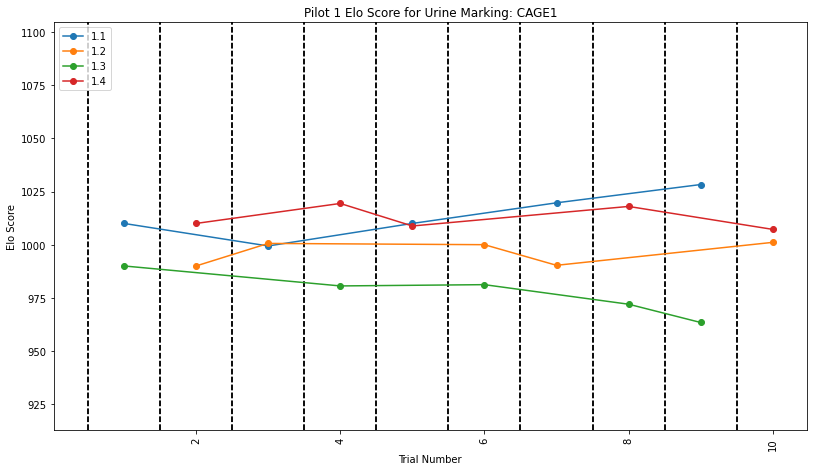

CAGE2


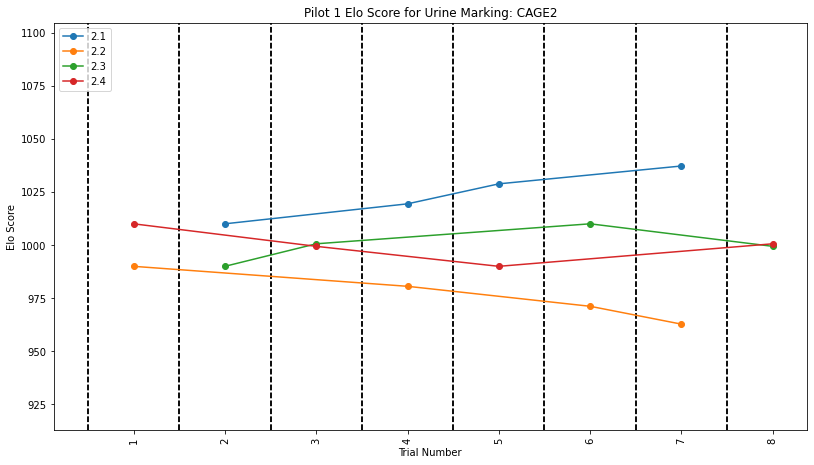

CAGE3


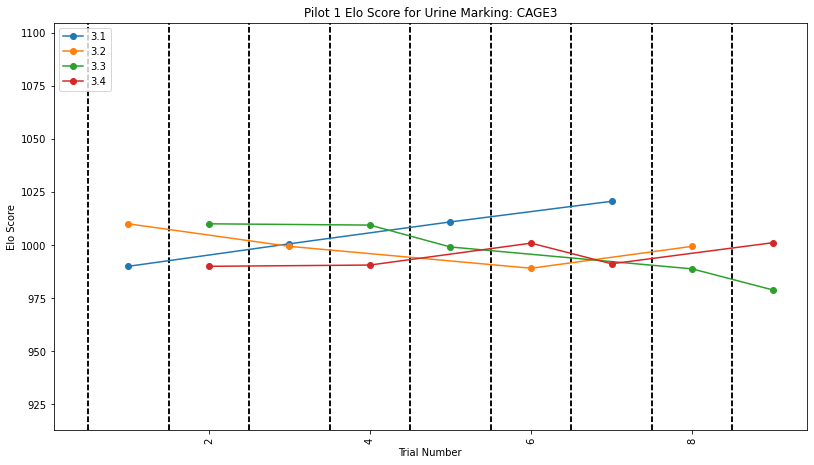

CAGE4


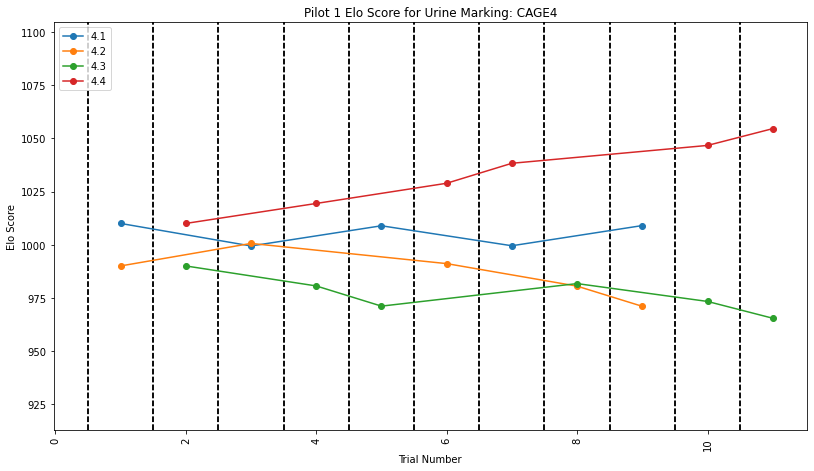

In [102]:
# Getting the highest and lowest ELO score for cutoffs of the Y-axis
max_elo_score = all_sheet_elo_scord_dataframe_combined["updated_elo_score"].max()
min_elo_score = all_sheet_elo_scord_dataframe_combined["updated_elo_score"].min()

# Making a plot for each sheet
for key, value in sheet_name_to_everything.items():
    plt.rcParams["figure.figsize"] = (13.5,7.5)
    print(key)
    elo_score_dataframe = value["elo_score_dataframe"]
    fig, ax = plt.subplots()        
        
    # Drawing vertical lines that represent when each session begins
    # Based on when a row has a different session than the previous row
    for index, row in elo_score_dataframe[elo_score_dataframe['session_number_difference'] != 0.0].iterrows():
        # Offsetting by 0.5 to avoid drawing the line on the dot
        plt.vlines(x=[row["total_match_number"] - 0.5], ymin=min_elo_score-50, ymax=max_elo_score+50, colors='black', linestyle='dashed')

    # Drawing a line for each subject
    for subject in sorted(elo_score_dataframe["subject_id"].unique()):
        # Getting all the rows with the current subject
        subject_dataframe = elo_score_dataframe[elo_score_dataframe["subject_id"] == subject]
        # Making the current match number the X-Axis
        plt.plot(subject_dataframe["total_match_number"], subject_dataframe["updated_elo_score"], '-o', label=subject)

    # Labeling the X/Y Axis and the title
    ax.set_xlabel("Trial Number")
    ax.set_ylabel("Elo Score")
    ax.set_title("{} Elo Score for {}: {}".format(" ".join(cohort_name.split("_")).capitalize(), string.capwords(" ".join(protocol_name.split("_"))), key))
    # To show the legend
    ax.legend(loc="upper left")
    plt.xticks(rotation=90)
    plt.ylim(min_elo_score-50, max_elo_score+50) 
    # Saving the plot
    file_name = "{}_{}_elo_score_{}_date_{}_{}.png".format(cohort_name, protocol_name, key, earliest_date, latest_date)
    file_name = "_".join(file_name.split(" "))
    plt.savefig(os.path.join(plot_output_directory, file_name))
    # Showing the plots
    plt.show()

# Saving the Dataframes

In [96]:
elo_score_spreadsheet_output_directory = "./proc/elo_score_spread_sheets/{}_elo_score/cage_{}_date_{}_{}".format(protocol_name, all_cages_string, earliest_date, latest_date)

In [97]:
elo_score_spreadsheet_output_directory

'./proc/elo_score_spread_sheets/urine_marking_elo_score/cage_1_2_3_4_date_2022-05-18_2022-06-01'

In [98]:
os.makedirs(elo_score_spreadsheet_output_directory, exist_ok=True)

In [99]:
file_name = "{}_elo_score_history_cages_{}_date_{}_{}.csv".format(protocol_name, all_cages_string, earliest_date, latest_date)
all_sheet_elo_scord_dataframe_combined.to_csv(os.path.join(elo_score_spreadsheet_output_directory, file_name))

In [100]:
file_name = "{}_final_elo_score_cages_{}_date_{}_{}.csv".format(protocol_name, all_cages_string, earliest_date, latest_date)
id_to_final_elo_score_df.to_csv(os.path.join(elo_score_spreadsheet_output_directory, file_name))